# REINFORCE算法
## 1.环境设置
本次环境设置
代理agent
- 停止条件：撞墙（可去）-100分，掉坑-100分，到达终点+100分
- 每走一步-1分
- gamma=0.99，学习率（步长）alpha=0.01
- 训练轮数2000轮

In [1]:
import random
import time

# 导入游戏库，定义游戏环境
import gym
import numpy as np
import pygame


# 定义游戏环境
class myFrozenLake(gym.Wrapper):
    def __init__(self):
        #is_slippery控制会不会滑
        env = gym.make('FrozenLake-v1',
                       render_mode='rgb_array',
                       is_slippery=False)
        super().__init__(env)
        self.env = env

    def reset(self):
        state, _ = self.env.reset()
        return state

    def step(self, action):

        # 获取当前状态
        current_state = self.env.s
        # 执行动作，获取结果
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        # 判断是否撞墙
        if state == current_state:
            reward = -100  # 撞墙扣10分
            # 相比于之前的实验，添加撞墙也会停止
            # 若不添加，agent就会一直撞墙，也不敢往其他地方走
            # over = True

        #走一步扣一分,逼迫机器人尽快结束游戏
        if not over:
            reward = -1

        #掉坑扣100分，游戏它本身规则就是掉坑就停止
        if over and reward == 0:
            reward = -100

        # 判断是否到达终点
        if over and reward == 1:  # 终点奖励本来就是1
            reward = 100  # 到达终点加10分

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()

## 2.REINFORCE算法代理的设置
算法核心公式
$$
\theta_{t+1} =\theta_{t}+\alpha\nabla_{\theta}\ln\pi(a_t|s_t,\theta_t)q_{t}(s_t,a_t)
$$
其中，
- $\theta$表示权重
- $\alpha$表示学习率
- $\nabla_{\theta}\ln\pi(a_t|s_t,\theta_t)$表示权重的梯度，本次实验使用线性方法并采用softmax得到
- $q_{t}(s_t,a_t)$当前状态的动作值

In [2]:
class REINFORCEAgent:
    def __init__(self, gameEnv, iterationNum=2000, epsilon=0.1, gamma=0.99, alpha=0.01):
        self.Env = gameEnv
        self.state_size = gameEnv.observation_space.n
        self.action_size = gameEnv.action_space.n
        self.iterNum = iterationNum
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha

        # 定义策略权重θ
        self.theta = np.zeros((16, 4))

    def select_action(self, current_state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        else:
            current_state_vector = np.eye(self.state_size)[current_state].reshape(-1, 1)
            return np.argmax(self.theta.T @ current_state_vector)

    def generate_episode(self):
        state_list, action_list, reward_list, next_state_list = [], [], [], []
        done = False
        s = self.Env.reset()
        while not done:
            a = self.select_action(s)
            ns, r, done = self.Env.step(a)
            state_list.append(s)
            action_list.append(a)
            reward_list.append(r)
            next_state_list.append(ns)
            s = ns
        return state_list, action_list, reward_list, next_state_list

    def Training(self):
        for k in range(self.iterNum):
            state_list, action_list, reward_list, next_state_list = self.generate_episode()
            Qsa = 0
            for t in range(len(state_list)):
                # 值更新
                Qsa += self.gamma ** (k - t) * reward_list[t]
                # 策略更新
                state_vector = np.eye(self.state_size)[state_list[t]].reshape(-1, 1)
                scores = self.theta.T @ state_vector
                probs = np.exp(scores) / np.sum(np.exp(scores))  # softmax 概率
                # 将 probs 的形状调整为与 state_vector 相匹配
                grad_ln_pi = state_vector - state_vector * probs.T# 策略梯度 (线性策略函数)
                grad_ln_pi = grad_ln_pi[:, 0]
                # 更新策略参数 theta
                self.theta[:, action_list[t]] += self.alpha * Qsa * grad_ln_pi
            if (k+1) % 10 == 0:
                print(f"Episode {k}, Total reward: {sum(reward_list)}")
        return self.theta

In [3]:
env = myFrozenLake()
agent = REINFORCEAgent(env)
theta = agent.Training()

Episode 9, Total reward: -106
Episode 19, Total reward: -123
Episode 29, Total reward: -115
Episode 39, Total reward: -163
Episode 49, Total reward: -102
Episode 59, Total reward: -132
Episode 69, Total reward: -101
Episode 79, Total reward: 95
Episode 89, Total reward: -112
Episode 99, Total reward: -104
Episode 109, Total reward: -104
Episode 119, Total reward: 95
Episode 129, Total reward: 95
Episode 139, Total reward: 95
Episode 149, Total reward: 95
Episode 159, Total reward: -104
Episode 169, Total reward: -108
Episode 179, Total reward: -103
Episode 189, Total reward: -104
Episode 199, Total reward: -101
Episode 209, Total reward: 95
Episode 219, Total reward: 95
Episode 229, Total reward: 95
Episode 239, Total reward: 95
Episode 249, Total reward: 95
Episode 259, Total reward: 95
Episode 269, Total reward: 95
Episode 279, Total reward: 95
Episode 289, Total reward: 95
Episode 299, Total reward: 95
Episode 309, Total reward: 91
Episode 319, Total reward: 95
Episode 329, Total re

In [4]:
best_Policy = np.zeros(16, dtype=int)
for state in range(env.observation_space.n):
    state_vector = np.eye(env.observation_space.n)[state].reshape(-1, 1)
    action = np.argmax(theta.T @ state_vector)
    best_Policy[state] = action
best_Policy

array([2, 2, 1, 2, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 2, 0])

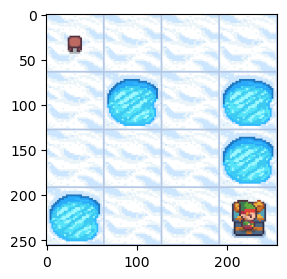

In [5]:
import time
from IPython import display


# 游戏显示
def play(env, policy):
    # 初始化状态
    s = env.reset()
    o = False
    while not o:
        # 当前状态采用的动作
        a = policy[s]
        # 获得下一步的状态，奖励，是否结束状态
        ns, r, o = env.step(a)
        # 状态更新进行下一步迭代
        s = ns
        # 打印图像
        display.clear_output(wait=True)
        time.sleep(0.2)
        env.show()
play(env, best_Policy)